In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
# Load only the first sheet (main)

#df = pd.read_excel('UK2025Risk.J.xlsx')
df = pd.read_excel('UK2024.J.xlsx')
#df = pd.read_excel('UK2023Risk.J.xlsx')
#df = pd.read_excel('UK2022Risk.J.xlsx')
#df = pd.read_excel('UK2021Risk.J.xlsx')


# Check if you have all the statuses you need (active, cancelled, complete, etc.)
print("Statuses found in data:")
print(df['tender_status'].value_counts())

Statuses found in data:
tender_status
complete    59110
active      14918
planning     1993
planned       651
Name: count, dtype: int64


In [6]:
df_main = df

In [7]:
# This lists EVERYTHING in that column, no matter the spelling or case
print(df_main['tender_status'].unique())

# This looks for any word that even looks like 'cancel'
print(df_main[df_main['tender_status'].str.contains('cancel', case=False, na=False)]['tender_status'].value_counts())

['active' 'complete' 'planning' 'planned']
Series([], Name: count, dtype: int64)


In [8]:
# Create a simple label for the Industry Sectors
# These are the standard CPV 'Divisions' Theo mentioned
sector_labels = {
    '45': 'Construction',
    '72': 'IT & Computer Services',
    '79': 'Consulting & Business',
    '85': 'Health & Social Work',
    '35': 'Security & Defense',
    '60': 'Transport'
}

# Extract the sector (first 2 digits) and apply the label
df['sector_code'] = df['tender_classification_id'].astype(str).str[:2]
df['industry_label'] = df['sector_code'].map(sector_labels).fillna('Other')

# Add the 1/0 switches for these industries (One-Hot Encoding)
# This replaces the biased classification_id in the PCA
df = pd.concat([df, pd.get_dummies(df['industry_label'], prefix='is')], axis=1)

# Add your standard flags and dates
df['sme_flag'] = df['tender_suitability_sme'].map({True: 1, False: 0}).fillna(0)
df['accelerated_flag'] = df['tender_procedure_isAccelerated'].map({True: 1, False: 0}).fillna(0)
df['lead_time_days'] = (pd.to_datetime(df['tender_contractPeriod_startDate'], utc=True) - 
                        pd.to_datetime(df['tender_datePublished'], utc=True)).dt.days.fillna(0)

In [9]:
# Select only columns that are numbers
X = df.select_dtypes(include=[np.number]).fillna(0)

# Standardize: Mean=0, Std=1
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA()
pca_results = pca.fit_transform(X_Scaled)

#3. how much risk signal did we find
print("Explained variance ratio (eignvalues /Lambda):")
print(pca.explained_variance_ratio_)


Explained variance ratio (eignvalues /Lambda):
[0.181279   0.17441338 0.16988074 0.16205495 0.15971598 0.15265594]


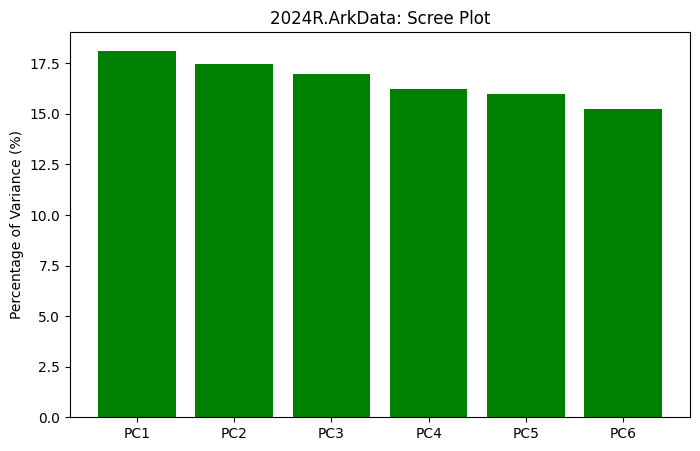

In [10]:
pc_labels = [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
variances = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(8, 5))
plt.bar(pc_labels, variances, color='green')
plt.ylabel('Percentage of Variance (%)')
plt.title('2024R.ArkData: Scree Plot')
plt.show()

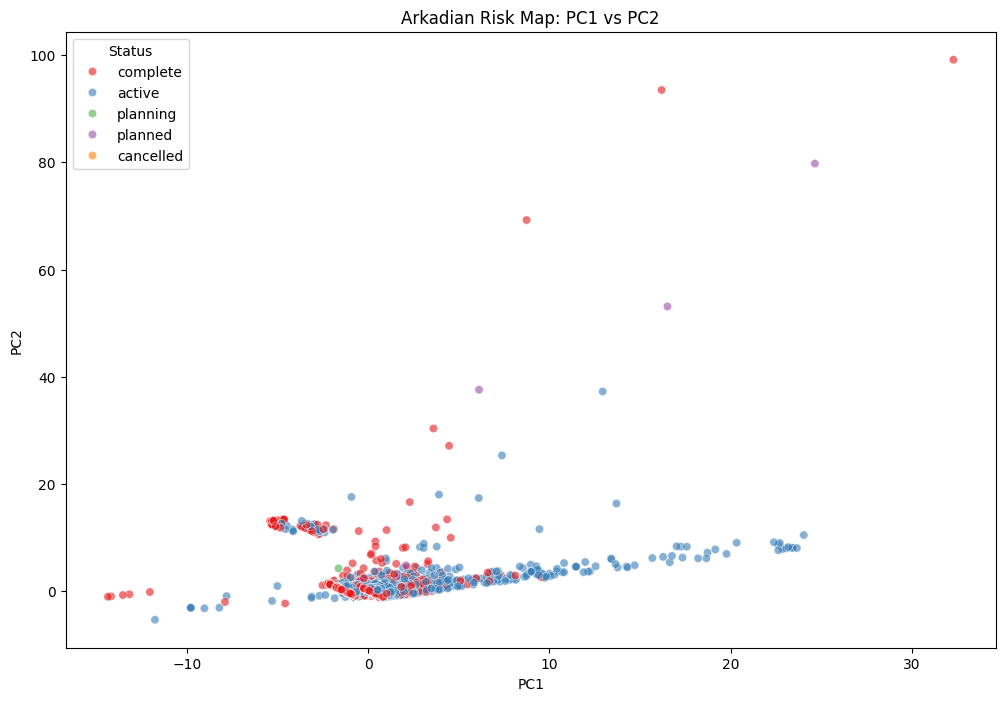

In [11]:
# Section 5: Risk Interpretation & Visuals

# Table with PC1,2 and Status
# We use the original columns you defined
pc_map = pd.DataFrame(pca_results[:, :2], columns=['PC1', 'PC2'])
pc_map['Status'] = df['tender_status'].values

# Draw map
plt.figure(figsize=(12, 8))

# EDIT: Added hue_order to force the rare/risk statuses to the front
# This prevents 'complete' (blue) from covering the red dots
sns.scatterplot(
    data=pc_map, 
    x='PC1', 
    y='PC2', 
    hue='Status', 
    hue_order=['complete', 'active', 'planning', 'planned', 'cancelled'],
    palette='Set1',
    alpha=0.6
)

plt.title('Arkadian Risk Map: PC1 vs PC2')
plt.show()

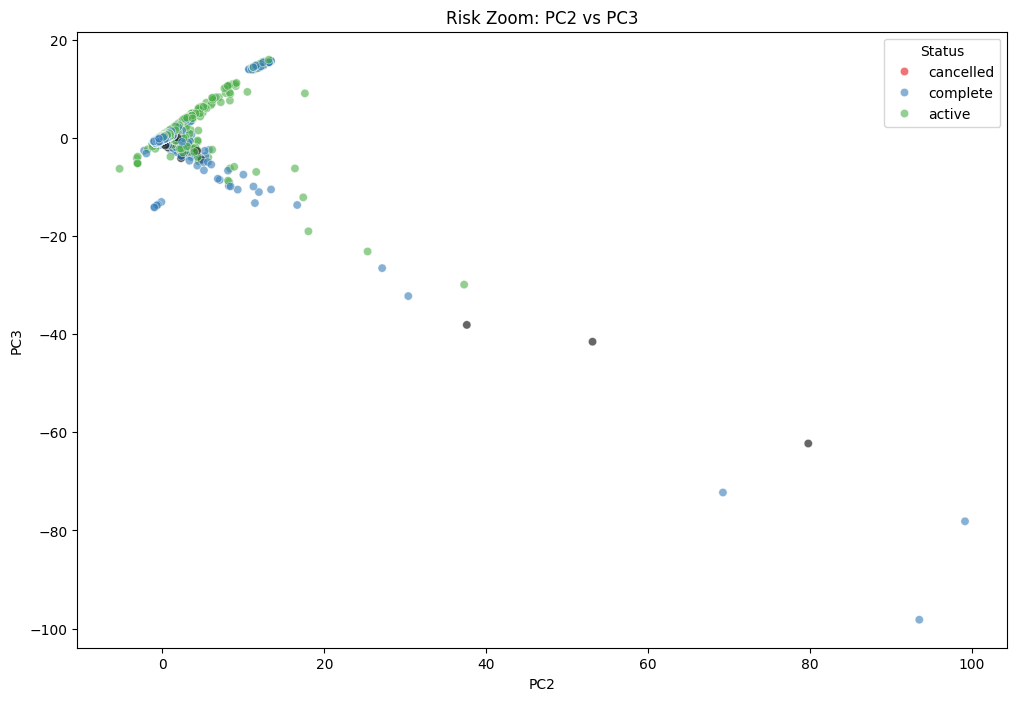

In [12]:
#Map PC2/PC3 (next factors)
pc_deep_map = pd.DataFrame(pca_results[:, 1:3], columns=['PC2', 'PC3'])
pc_deep_map['Status'] = df['tender_status'].values

#Plot, but bring cancelled to  front
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pc_deep_map, x='PC2', y='PC3', hue='Status', 
                hue_order=['cancelled', 'complete', 'active'], # Forces red to top
                alpha=0.6, palette='Set1')
plt.title('Risk Zoom: PC2 vs PC3')
plt.show()

In [13]:
# Create loadings table for all variables
# We use X.columns because that is the final table we sent to the PCA
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
    index=X.columns
)

# Look at the recipe for PC2/3
print("-PC2 Drivers-")
print(loadings['PC2'].sort_values(ascending=False))

print("\n-PC3 Drivers-")
print(loadings['PC3'].sort_values(ascending=False))

-PC2 Drivers-
tender_value_amount         0.526154
tender_minValue_amount      0.487955
accelerated_flag            0.449735
lead_time_days              0.237396
sme_flag                   -0.096694
tender_classification_id   -0.465934
Name: PC2, dtype: float64

-PC3 Drivers-
accelerated_flag            0.563742
lead_time_days              0.299406
sme_flag                    0.160443
tender_classification_id   -0.351863
tender_value_amount        -0.420860
tender_minValue_amount     -0.515633
Name: PC3, dtype: float64
